In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
import tensorflow_datasets as tfds
import pathlib
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
import os
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet
from tensorflow.image import ssim
from tensorflow.keras.losses import MeanAbsoluteError

In [8]:
#----------------------------------------------------------------------------------------------
#CHARGER ET TRANSFORMER LES DONNES
tf.random.set_seed(123)

# Directory where the images are located
image_dir = r'D:\DATA_PROJET_ML1\landscape-pictures'

# Create a dataset of all image files in the directory
image_paths = pathlib.Path(image_dir).glob('*.jpg')
image_paths = [str(path) for path in image_paths]
image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)

In [9]:
# Function to load and preprocess each image, convert it to grayscale and normalize
def to_grayscale(image):
    return tf.image.rgb_to_grayscale(image)

def normalize(image):
    return tf.cast(image, tf.float32) / 255.0


def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [128, 128])
    return image

def count_elements(dataset):
    return len(list(dataset))

def convert_grayscale_to_rgb(image):
    return tf.concat([image, image, image], axis=-1)


In [10]:
# Load and preprocess the images
image_dataset = image_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

num_images = image_dataset.cardinality().numpy()
num_train_images = int(0.8 * num_images)
normalized_dataset = image_dataset.map(normalize)
train_dataset = normalized_dataset.take(num_train_images)
val_dataset = normalized_dataset.skip(num_train_images)

train_dataset_gray = train_dataset.map(to_grayscale)
val_dataset_gray = val_dataset.map(to_grayscale)

train_dataset_rgb = train_dataset_gray.map(convert_grayscale_to_rgb)
val_dataset_rgb = val_dataset_gray.map(convert_grayscale_to_rgb)


BATCH_SIZE = 32
train_data = tf.data.Dataset.zip((train_dataset_rgb, train_dataset))
val_data = tf.data.Dataset.zip((val_dataset_rgb, val_dataset))
train_data = train_data.batch(BATCH_SIZE).prefetch(1)
val_data = val_data.batch(BATCH_SIZE).prefetch(1)

In [11]:
#----------------------------------------------------------------------------------------------
#DEFINIR LE MODELE


# Load pretrained MobileNet model without the top classification layers
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(128, 128, 3))


In [12]:
# Ensure the MobileNet layers are non-trainable
for layer in base_model.layers:
    layer.trainable = False

# Encoder layers
encoder1 = base_model.get_layer('conv_pw_1_relu').output  # 64x64
encoder2 = base_model.get_layer('conv_pw_3_relu').output  # 32x32
encoder3 = base_model.get_layer('conv_pw_5_relu').output  # 16x16
encoder4 = base_model.get_layer('conv_pw_11_relu').output  # 8x8
# encoder5 is removed since we are using encoder4 as the bottleneck

# Center - bottleneck is now 8x8
center = encoder4  # 8x8, this is now the bottleneck

# Decoder
u6 = UpSampling2D((2, 2))(center)  # Upsamples to 16x16
u6 = concatenate([u6, encoder3])  # Concatenate with encoder3
u6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
u6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)

u7 = UpSampling2D((2, 2))(u6)  # Upsamples to 32x32
u7 = concatenate([u7, encoder2])  # Concatenate with encoder2
u7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
u7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)

u8 = UpSampling2D((2, 2))(u7)  # Upsamples to 64x64
u8 = concatenate([u8, encoder1])  # Concatenate with encoder1
u8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
u8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)

u9 = UpSampling2D((2, 2))(u8)  # Upsamples to 128x128
# No need to concatenate with any encoder layer now, as we are at the full resolution
u9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
u9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)

# Final convolution
outputs = Conv2D(3, (1, 1), activation='sigmoid')(u9)  # 128x128, 3 channels


In [13]:
model = Model(inputs=base_model.input, outputs=outputs)

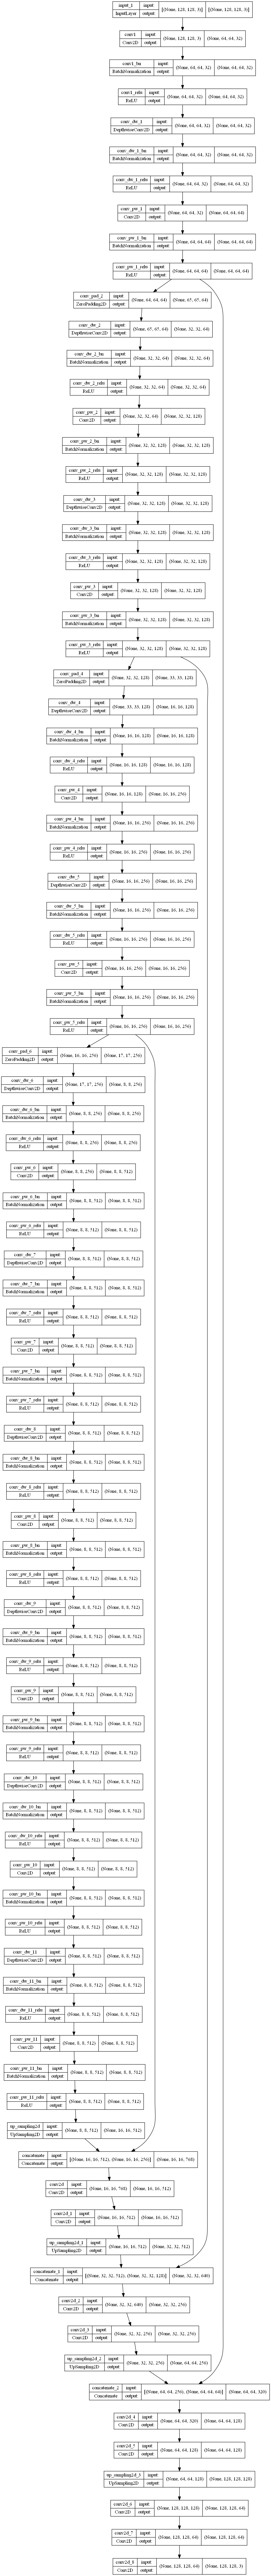

In [14]:
from keras.utils.vis_utils import plot_model


# Créer et sauvegarder le diagramme du modèle
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


In [15]:
#----------------------------------------------------------------------------------------------
#TRAINING
def combined_loss(y_true, y_pred):
    # Calculate mean absolute error
    mae = MeanAbsoluteError()(y_true, y_pred)
    # Calculate SSIM loss as 1 - mean SSIM
    ssim_loss = 1 - tf.reduce_mean(ssim(y_true, y_pred, max_val=1.0))
    # Weight the losses and combine
    combined = (0.7 * ssim_loss) + (0.3 * mae)
    return combined

model = Model(inputs=base_model.input, outputs=outputs)

optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss=combined_loss)  # Changed to mean squared error as discussed
epochs = 100

#Callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1, min_delta=1e-4, min_lr=0.000001)
#checkpoint = ModelCheckpoint("model_at_epoch_{epoch}.h5", save_freq='epoch')

# Fit the model to the data
history = model.fit(train_data, validation_data=val_data, epochs=epochs, batch_size=BATCH_SIZE, callbacks=[early_stopping, reduce_lr])


Epoch 1/100
108/108 [==============================] - 81s 628ms/step - loss: 0.2752 - val_loss: 0.2093 - lr: 1.0000e-04
Epoch 2/100
108/108 [==============================] - 62s 578ms/step - loss: 0.1751 - val_loss: 0.1664 - lr: 1.0000e-04
Epoch 3/100
108/108 [==============================] - 64s 592ms/step - loss: 0.1495 - val_loss: 0.1475 - lr: 1.0000e-04
Epoch 4/100
108/108 [==============================] - 63s 587ms/step - loss: 0.1346 - val_loss: 0.1331 - lr: 1.0000e-04
Epoch 5/100
108/108 [==============================] - 64s 590ms/step - loss: 0.1264 - val_loss: 0.1262 - lr: 1.0000e-04
Epoch 6/100
108/108 [==============================] - 64s 591ms/step - loss: 0.1201 - val_loss: 0.1189 - lr: 1.0000e-04
Epoch 7/100
108/108 [==============================] - 64s 593ms/step - loss: 0.1151 - val_loss: 0.1128 - lr: 1.0000e-04
Epoch 8/100
108/108 [==============================] - 64s 593ms/step - loss: 0.1118 - val_loss: 0.1124 - lr: 1.0000e-04
Epoch 9/100
108/108 [===========

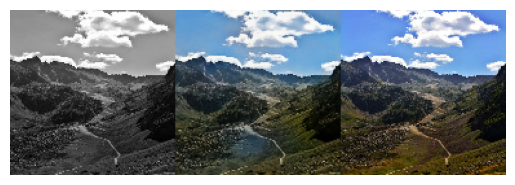

In [16]:

#-----------------------------------------------------------------------------------------------
##TEST AVEC DES NOUVELLES IMAGES
def duplicate_channels(image):
    return tf.repeat(image, repeats=3, axis=-1)

imgs_gray = val_dataset_gray.take(20)
imgs_color = val_dataset.take(20)

imgs_gray_3_channels = imgs_gray.map(duplicate_channels)

# Use the generator to colorize the images
imgs_colorized = model.predict(imgs_gray_3_channels.batch(1))  # Add batch dimension for prediction

# Iterate over the images
for i, (img_gray, img_color, img_colorized) in enumerate(zip(imgs_gray, imgs_color, imgs_colorized)):
    # Rescale the pixel values from [0, 1] to [0, 255]
    img_gray = (img_gray.numpy() * 255).astype(np.uint8)
    img_color = (img_color.numpy() * 255).astype(np.uint8)
    img_colorized = ((imgs_colorized[i] * 255).astype(np.uint8))

    # Convert grayscale image to RGB
    img_gray_rgb = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2RGB)

    # Concatenate the grayscale, colorized and original RGB images
    img_combined = np.concatenate((img_gray_rgb, img_colorized, img_color), axis=1)

    # Save the combined image
    plt.imshow(img_combined)
    plt.axis('off')
    #plt.savefig(f'colorized_images/image_ResNet{i}.png')


In [17]:
#----------------------------------------------------------------------------------------------
##SAUVEGARDER MODELE AU BESOIN
model.save(f'unetMobileNetv2.h5')